# Star formation rate surface density and pressure relationships: 
## TIGRESS model comparison

In [1]:
%matplotlib inline

### First need to import standard python packages: 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as spst
import astropy.constants as c
import astropy.units as u
import pandas as pd
#import cPickle as p
import pickle as p

In [3]:
#setup for making matplotlib figures 
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize']=10,10
plt.rcParams.update({'font.size': 18})

In [4]:
np.set_printoptions(threshold=1500)

In [5]:
#Set up your matplotlib figure output directory here
import os
outpath='/tigress/eostrike/figs'

### To read and extract information from TIGRESS data we use modules from the pyathena package

In [6]:
import sys
sys.path.insert(0,'../')
import pyathena as pa
pa.__file__
from pyathena import preprocessing
from pyathena.set_plt import labels,label_units

In [7]:
plt.__file__

'/tigress/eostrike/miniconda2/envs/py3/lib/python3.7/site-packages/matplotlib/pyplot.py'

## Unit system

The unit system for the TIGRESS simulations is
* [length] = pc
* [velocity] = km/s
* [density] = 1.4271*m_H/cm^3

In [8]:
#We use set_units from pyathena for units conversions
# This uses units and constants from astropy
from pyathena import set_units
set_units

<function set_units.set_units(dunit=None, lunit=None, vunit=None, cgs=False, muH=1.4)>

In [9]:
unit=pa.set_units(muH=1.4271)
print (unit['density'].cgs/1.4271/c.m_p.cgs)
print (unit['velocity'])
print (unit['length'])
print (unit['mass'])
print (unit['time'])
print (unit['magnetic_field'])

1.0 1 / cm3
1.0 km / s
1.0 pc
0.03526822429848302 solMass
0.9777922216731284 Myr
0.5476852239548456 uG


In [10]:
# other units can be easily obtained
print (unit.keys())

dict_keys(['muH', 'density', 'velocity', 'length', 'time', 'pressure', 'gravitational_potential', 'number_density', 'magnetic_field', 'temperature', 'mass'])


In [11]:
#These are useful for conversions 
codemass=unit['mass']
codetime=unit['time']
codelength=unit['length']
codevel=unit['velocity']
print (codemass,codetime,codelength,codevel)

0.03526822429848302 solMass 0.9777922216731284 Myr 1.0 pc 1.0 km / s


In [12]:
#For converting from code units to useful astronomical units
Myr=unit['time'].to('Myr').value
Msun=unit['mass'].to('Msun').value
pok=(unit['pressure']/c.k_B).cgs.value
surf=(unit['density']*unit['length']).to('Msun/pc^2').value
print (Myr,Msun,pok,surf)

0.9777922216731284 0.03526822429848302 172.88967293687466 0.035268224298483024


# Standard set of models for SFR analysis are the following:

 * Models with varying surface density and gravity, all with standard "classic TIGRESS" SN feedback, heating + cooling:
    * `R2_2pc_L512_B2_norun`,`R4_2pc_L512_B10`,`R8_4pc_newacc`,`R16_8pc_metal`: standard gravity
    * `LGR2_2pc_L512_B10`,`LGR4_2pc_L512_B10`,`LGR8_4pc_FUVcorr`: low gravity
 

* Movies of models available at:
 http://tigress-web.princeton.edu/~changgoo/TIGRESS_figures/movies/
 
 * Variants of the "Solar neighborhood" based on restarts of R8_8pc model to test physics effects
    * `R8_8pc_rst`: "classic TIGRESS"
    * `R8_8pc_rst_hydro`: unmagnetized
    * `R8_8pc_rst_noFeedback`: both PE heating and SNe turned off
    * `R8_8pc_rst_noFUV`: PE heating turned off (includes heating from metagalactic UV)
    * `R8_8pc_rst_noSN`: SNe turned off
    * `R8_8pc_rst_noext`: no stellar gravity (has gravity from DM to keep gas in midplane)
 * Comparison movie of variants available at:
http://tigress-web.princeton.edu/~changgoo/TIGRESS_figures/R8_comp_surf/R8_comp_surf.mp4

*  Additional variants with corrected FUV:
    * `R8_8pc_rst_FUVcorr`: standard Solar neighborhood
    * `R8_8pc_rst_norot`: turned off rotation (CMB foreground purpose)
    * `R8_8pc_rst_noSN2`: SN turned off
        
       

  
## See https://github.com/PrincetonUniversity/Athena-TIGRESS/wiki/Data for description of parameters

* Earlier sets of suggested models are:
  * `pids=['R2_2pc_L256_B2','R4_4pc_L512_B2','R8_4pc_newacc','R16_8pc_metal','LGR2_2pc_metal','LGR4_4pc_newacc', 'LGR8_8pc_newacc']`
  * `pids=['R2_2pc_metal','R4_4pc_metal','R8_8pc_metal','R16_16pc_metal','LGR2_2pc_metal','LGR4_4pc_metal','LGR8_8pc_metal']`

* Additional models: 
  * `R2_4pc_L512_B2_norun`,`R2_4pc_L1024_B2_norun `, `R2_8pc_L1024_B2_norun` (no runaways)
  * `R4_2pc_L512_B10`,`R4_8pc_L1024_B2_norun `,`R8_2pc_rst`, `R8_8pc_rst`, `R16_16pc_metal`


### Set up for reading in pre-processed extended history from TIGRESS simulations
### Names and definitions of all variables are in /pyathena/preprocessing.py

In [13]:
#simulation output file directory information
#base directory
base='/tigress/changgoo/'
#problem ids for simulations to be compared
#Standard models:
pids=['R2_2pc_L512_B2_norun','R4_2pc_L512_B10','R8_4pc_newacc','R16_8pc_metal']
pidsLG=['LGR2_2pc_L512_B10','LGR4_2pc_L512_B10','LGR8_4pc_FUVcorr']
#previous sets of models:
#pids=['R2_2pc_L256_B2','R4_4pc_L512_B2','R8_4pc_newacc','R16_16pc_metal']
#pidsLG=['LGR2_2pc_metal','LGR4_4pc_newacc','LGR8_8pc_newacc']
#pids+=['LGR2_2pc_metal','LGR4_4pc_newacc','LGR8_8pc_newacc']
#pids_old=['R2_2pc_metal','R4_4pc_metal','R8_8pc_metal','R16_16pc_metal','LGR2_2pc_metal','LGR4_4pc_metal','LGR8_8pc_metal']
pidsall=pids+pidsLG

In [14]:
for i, pid in enumerate(pidsall):
    print (i,pid)

0 R2_2pc_L512_B2_norun
1 R4_2pc_L512_B10
2 R8_4pc_newacc
3 R16_8pc_metal
4 LGR2_2pc_L512_B10
5 LGR4_2pc_L512_B10
6 LGR8_4pc_FUVcorr


In [15]:
#physics variant models 
pids_phys=['R8_8pc_rst','R8_8pc_rst_hydro','R8_8pc_rst_noFeedback','R8_8pc_rst_noFUV','R8_8pc_rst_noSN','R8_8pc_rst_noext']
#FUV corr models:
pids_FUVcorr=['R8_8pc_rst_FUVcorr','R8_8pc_rst_norot','R8_8pc_rst_noSN2']
for i, pid in enumerate(pids_phys+pids_FUVcorr):
    print (i,pid)

0 R8_8pc_rst
1 R8_8pc_rst_hydro
2 R8_8pc_rst_noFeedback
3 R8_8pc_rst_noFUV
4 R8_8pc_rst_noSN
5 R8_8pc_rst_noext
6 R8_8pc_rst_FUVcorr
7 R8_8pc_rst_norot
8 R8_8pc_rst_noSN2


In [16]:
# run the following script if there is no hst_zp.p pickle file already created in the directory for a given run

#for pid in pids:
#    preprocessing.doall(base,pid,problem_dir=pid,do_pickling=False)

In [17]:
#Construct history filenames, load history data into hsts dictionary, load parameter information into pars dictionary
hsts={}
pars={}
for pid in pidsall:
    hstzp_filename='{}{}/hst/{}.hst_zp.p'.format(base,pid,pid)
#    hsts[pid]=p.load(open(hstzp_filename))
    hsts[pid]=pd.read_pickle(hstzp_filename)
    par_filename='{}{}/{}.par'.format(base,pid,pid)
    pars[pid]=pa.get_params(par_filename)

In [19]:
#Do the same for the physics variants
hsts_ph={}
pars_ph={}
for pid in pids_phys:
    hstzp_filename='{}{}/hst/{}.hst_zp.p'.format(base,pid,pid)
    hsts_ph[pid]=pd.read_pickle(hstzp_filename)
    par_filename='{}{}/{}.par'.format(base,pid,pid)
    pars_ph[pid]=pa.get_params(par_filename)    

In [23]:
print (pars.keys())
print (pars_ph.keys())

dict_keys(['R2_2pc_L512_B2_norun', 'R4_2pc_L512_B10', 'R8_4pc_newacc', 'R16_8pc_metal', 'LGR2_2pc_L512_B10', 'LGR4_2pc_L512_B10', 'LGR8_4pc_FUVcorr'])
dict_keys(['R8_8pc_rst', 'R8_8pc_rst_hydro', 'R8_8pc_rst_noFeedback', 'R8_8pc_rst_noFUV', 'R8_8pc_rst_noSN', 'R8_8pc_rst_noext'])


In [24]:
print (pars['R8_4pc_newacc'])
#print pars['R8_4pc_newacc'].keys()
#print pars['R8_4pc_newacc'].values()
#for key,val in pars['R8_4pc_newacc'].items():
#    print key,val

{'level': 0.0, 'Nx1': 256.0, 'x1min': -512.0, 'x1max': 512.0, 'bc_ix1': 4.0, 'bc_ox1': 4.0, 'NGrid_x1': 4.0, 'Nx2': 256.0, 'x2min': -512.0, 'x2max': 512.0, 'bc_ix2': 4.0, 'bc_ox2': 4.0, 'NGrid_x2': 4.0, 'Nx3': 1792.0, 'x3min': -3584.0, 'x3max': 3584.0, 'bc_ix3': 2.0, 'bc_ox3': 2.0, 'NGrid_x3': 28.0, 'AutoWithNProc': 0.0, 'gamma': 1.66666667, 'surf': 12.0, 'sz0': 10.0, 'vturb': 10.0, 'beta': 10.0, 'Omega': 0.028, 'qshear': 1.0, 'SurfS': 42.0, 'zstar': 245.0, 'rhodm': 0.0064, 'R0': 8000.0, 'Sigma_SFR': 0.005, 'rho_crit': 1.0, 'SFUV0': 6.8, 'fbin': 0.6666667, 'fdyn': 0.0, 'MejII': 10.0, 'ZII': 0.2, 'eps': 1.0, 'iSN': 5.0, 'iFUV': 1.0, 'nscalars': 3}


In [25]:
print (pars['LGR8_4pc_FUVcorr']['Omega'])

0.015


In [26]:
#the history data is stored in a pandas dataframe
type(hsts['R8_4pc_newacc'])

pandas.core.frame.DataFrame

In [27]:
#history index is the time in code units. time in Myr and orbits also available
print (hsts['R8_4pc_newacc'][['tMyr','torb']][0:20])

               tMyr      torb
taxis                        
0.00000    0.000000  0.000000
1.00412    0.981821  0.004475
2.00044    1.956015  0.008915
3.00590    2.939146  0.013395
4.00193    3.913056  0.017834
5.00722    4.896021  0.022314
6.00569    5.872317  0.026763
7.00706    6.851449  0.031226
8.00620    7.828400  0.035678
9.00146    8.801558  0.040114
10.00720   9.784962  0.044595
11.00160  10.757279  0.049027
12.00400  11.737418  0.053494
13.00610  12.717263  0.057960
14.00150  13.690558  0.062395
15.00360  14.670403  0.066861
16.00090  15.645556  0.071305
17.00230  16.624717  0.075768
18.00000  17.600260  0.080214
19.00270  18.580692  0.084682


In [28]:
#there are a lot of variables 
print (hsts['R8_4pc_newacc'].columns.size)
print (np.sort(hsts['R8_4pc_newacc'].columns.values))


1240
['EB' 'EB1' 'EB1_2p' 'EB1_c' 'EB1_h' 'EB1_h1' 'EB1_h2' 'EB1_turb'
 'EB1_turb_2p' 'EB1_turb_c' 'EB1_turb_h' 'EB1_turb_h1' 'EB1_turb_h2'
 'EB1_turb_u' 'EB1_turb_w' 'EB1_u' 'EB1_w' 'EB2' 'EB2_2p' 'EB2_c' 'EB2_h'
 'EB2_h1' 'EB2_h2' 'EB2_turb' 'EB2_turb_2p' 'EB2_turb_c' 'EB2_turb_h'
 'EB2_turb_h1' 'EB2_turb_h2' 'EB2_turb_u' 'EB2_turb_w' 'EB2_u' 'EB2_w'
 'EB3' 'EB3_2p' 'EB3_c' 'EB3_h' 'EB3_h1' 'EB3_h2' 'EB3_turb' 'EB3_turb_2p'
 'EB3_turb_c' 'EB3_turb_h' 'EB3_turb_h1' 'EB3_turb_h2' 'EB3_turb_u'
 'EB3_turb_w' 'EB3_u' 'EB3_w' 'EB_2p' 'EB_c' 'EB_h' 'EB_h1' 'EB_h2'
 'EB_turb' 'EB_turb_2p' 'EB_turb_c' 'EB_turb_h' 'EB_turb_h1' 'EB_turb_h2'
 'EB_turb_u' 'EB_turb_w' 'EB_u' 'EB_w' 'Ek' 'Ek1' 'Ek1_2p' 'Ek1_c' 'Ek1_h'
 'Ek1_h1' 'Ek1_h2' 'Ek1_u' 'Ek1_w' 'Ek2' 'Ek2_2p' 'Ek2_c' 'Ek2_h' 'Ek2_h1'
 'Ek2_h2' 'Ek2_u' 'Ek2_w' 'Ek3' 'Ek3_2p' 'Ek3_c' 'Ek3_h' 'Ek3_h1' 'Ek3_h2'
 'Ek3_u' 'Ek3_w' 'Ek_2p' 'Ek_c' 'Ek_h' 'Ek_h1' 'Ek_h2' 'Ek_u' 'Ek_w' 'Eth'
 'Eth_2p' 'Eth_c' 'Eth_h' 'Eth_h1' 'Eth_h2' 'Eth_u' 'Eth_w' 

In [29]:
#surface density is in units Msun/pc^2, pressure is P/k in units cm^-3 K, star formation rate is in units Msun/pc^2/Myr
print (hsts['R8_4pc_newacc'][['surf','surf_2p','Pmid','Pmid_2p','sfr10','sfr40']][200:220])

              surf    surf_2p          Pmid       Pmid_2p     sfr10     sfr40
taxis                                                                        
200.000  10.786783  10.692059  18011.717636  21020.260105  0.004703  0.006728
201.001  10.782290  10.688418  18875.634688  20773.785254  0.004151  0.006840
202.001  10.782365  10.682824  17750.072272  21185.791138  0.002402  0.006840
203.001  10.782579  10.684071  19171.960241  22240.615071  0.002402  0.006762
204.001  10.782637  10.681655  18500.719168  22187.478908  0.002395  0.006762
205.000  10.782818  10.689264  26641.180694  20705.828523  0.001636  0.006762
206.000  10.783070  10.685670  17763.937224  21122.869644  0.001267  0.006762
207.000  10.783326  10.682704  24859.648673  21099.255432  0.001267  0.006675
208.001  10.783333  10.673687  18567.663794  18062.273796  0.001267  0.006577
209.001  10.779448  10.669378  11969.501894  19115.137551  0.001494  0.006454
210.000  10.779458  10.673699  19129.936086  19646.785986  0.001

In [37]:
for pid in pidsall:
    model=pid.split('_')[0]
    p=pars[pid]
    torb=2*np.pi/p['Omega']
    print (model, torb)

R2 62.83185307179586
R4 116.93737171661132
R8 224.39947525641378
R16 530.1013521851028
LGR2 125.66370614359172
LGR4 209.43951023931956
LGR8 418.8790204786391


In [38]:
for pid in pids_phys[1:]:
    model=pid.split('_')[3]
    print (model)

hydro
noFeedback
noFUV
noSN
noext


In [63]:
modname_ph={}
modname_ph['R8_8pc_rst']='All'
modname_ph['R8_8pc_rst_hydro']='noMHD'
for pid in pids_phys[2:]:
    model=pid.split('_')[3]
    modname_ph[pid]=model
print (modname_ph.values())

dict_values(['All', 'noMHD', 'noFeedback', 'noFUV', 'noSN', 'noext'])


In [121]:
#print (hsts['R8_4pc_newacc'][['tMyr','surf']][70:90])


Text(0, 0.5, '$\\Sigma$$\\,[{\\rm M_\\odot pc^{-2}}]$')

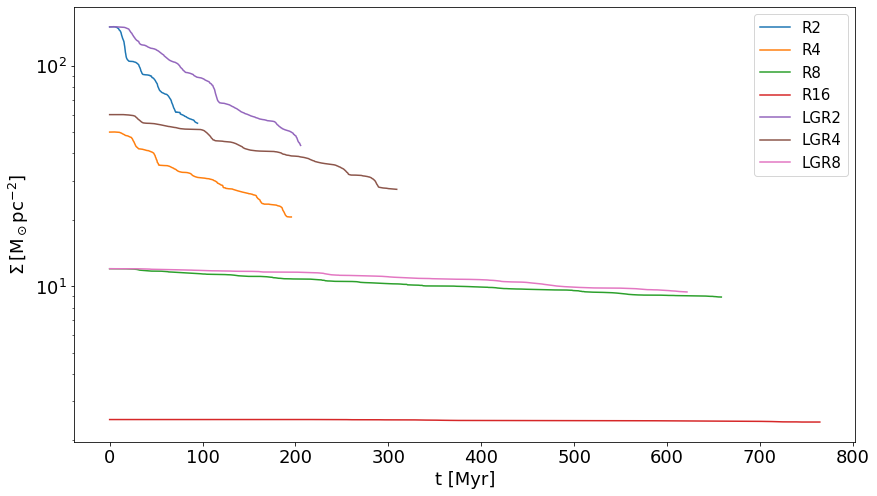

In [40]:
plt.figure(figsize=(14,8))
for pid in pidsall:
    h=hsts[pid]
    p=pars[pid]
    model=pid.split('_')[0]
    plt.semilogy(h['tMyr'],h['surf'],label=model)
plt.legend(fontsize='small')
plt.xlabel('t [Myr]')
plt.ylabel(labels['surf']+label_units['surf'])

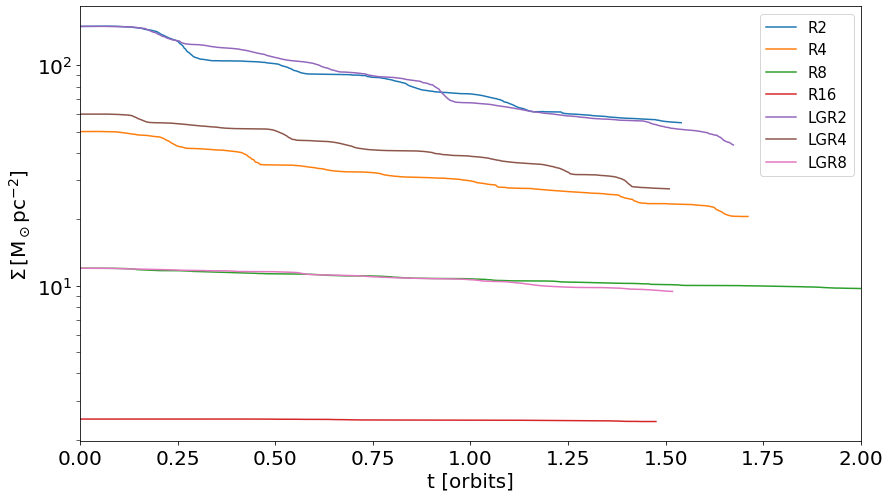

In [90]:
#Surface density evolution
plt.figure(figsize=(14,8))
for pid in pidsall:
    h=hsts[pid]
    p=pars[pid]
    model=pid.split('_')[0]
    torb=2*np.pi/p['Omega']
    plt.semilogy(h.index/torb,h['surf'],label=model)
plt.legend(fontsize='small')
plt.xlabel('t [orbits]',fontsize=20)
plt.ylabel(labels['surf']+label_units['surf'],fontsize=20)
plt.xlim([0,2.0])
plt.tick_params(labelsize=20,length=4,which='both')

In [81]:
for pid in pidsall:
    h=hsts[pid]
    idx=(h['tMyr']>40)
    model=pid.split('_')[0]
    print (model, np.percentile(h['surf'][idx],[25,50,75]))

R2 [58.95307894 67.38734988 77.39958359]
R4 [25.831636   29.14655562 32.82577885]
R8 [ 9.52646293 10.01723208 10.792885  ]
R16 [2.45278202 2.45919437 2.4834282 ]
LGR2 [57.0198725  67.51983873 93.42490407]
LGR4 [35.49906874 40.86310347 48.37150508]
LGR8 [10.08183545 10.86111341 11.58129268]


In [92]:
#choose range of surface density for averages in limited density range for standard models
surf_min={'R2':60,'R4':25,'R8':9,'R16':2.4,'LGR2':60,'LGR4':35,'LGR8':10,}
surf_max={'R2':80,'R4':35,'R8':11,'R16':2.6,'LGR2':80,'LGR4':45,'LGR8':12}
surf_mean={'R2':70,'R4':30,'R8':10,'R16':2.5,'LGR2':70,'LGR4':40,'LGR8':11}
#choose minimum time for plotting (in Myr)
tmin_min=40.    

Text(0, 0.5, '$\\Sigma$$\\,[{\\rm M_\\odot pc^{-2}}]$')

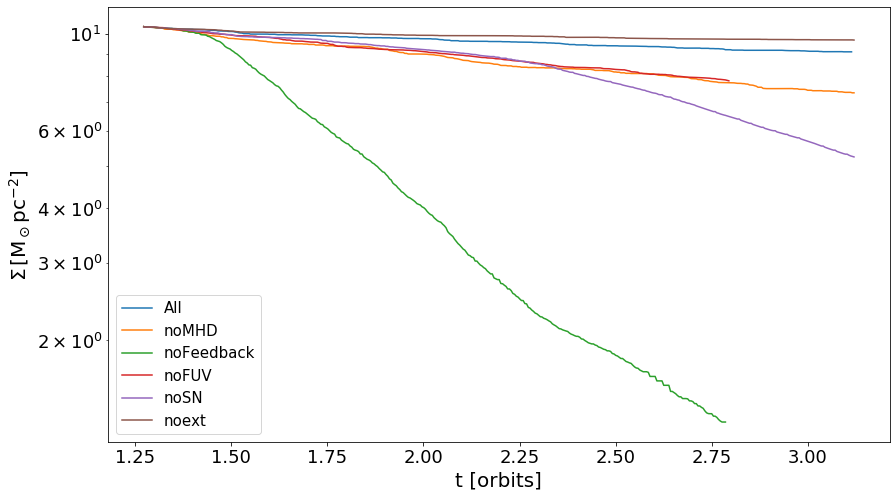

In [64]:
#Surface density evolution for physics variants
plt.figure(figsize=(14,8))
for pid in pids_phys:
    h=hsts_ph[pid]
    p=pars_ph[pid]
    model = modname_ph[pid]
    torb=2*np.pi/p['Omega']
    plt.semilogy(h.index/torb,h['surf'],label=model)
plt.legend(fontsize='small')
plt.xlabel('t [orbits]',fontsize=20)
plt.ylabel(labels['surf']+label_units['surf'],fontsize=20)
#plt.xlim([0,2.0])

In [93]:
for pid in pids_phys:
    h=hsts_ph[pid]
    model=modname_ph[pid]
    print (model, np.percentile(h['surf'],[25,50,75]))

All [9.29437101 9.58839643 9.88379812]
noMHD [7.96603496 8.49924244 9.41454663]
noFeedback [2.03243441 3.80563608 7.11343362]
noFUV [8.36708995 9.0437223  9.66306513]
noSN [7.07695436 8.82888093 9.69120953]
noext [ 9.72253996  9.88583547 10.02864494]


In [94]:
#range of surface density for physics variants
surf_min={'All':9.3, 'noMHD':8.0, 'noFeedback':3.,'noFUV':8.5,'noSN':7.,'noext':9.7 }
surf_mean={'All':9.6, 'noMHD':8.5, 'noFeedback':4.,'noFUV':9.,'noSN':8.,'noext':9.9 }
surf_max={'All':9.9, 'noMHD':9.0, 'noFeedback':5.,'noFUV':9.5,'noSN':9.,'noext':10.1 }

(0, 2.0)

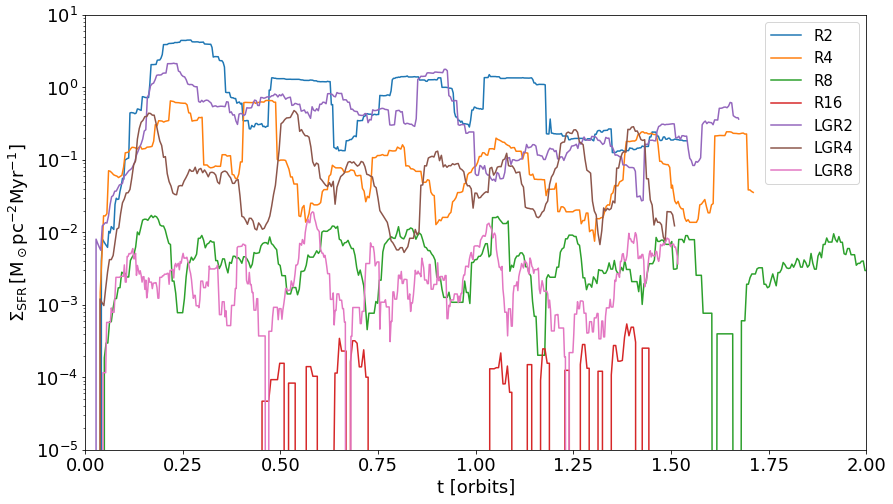

In [95]:
#Star formation rate averaged over 10 Myr
plt.figure(figsize=(14,8))
for pid in pidsall:
    h=hsts[pid]
    p=pars[pid]
    model=pid.split('_')[0]
    torb=2*np.pi/p['Omega']
#    plt.semilogy(h.index/torb,h['sfr10'],label=model)
#note that this is the same:
    plt.semilogy(h['torb'],h['sfr10'],label=model,linestyle="-" )        
plt.ylim(1.e-5,10)
plt.legend(fontsize='small')
plt.xlabel('t [orbits]')
plt.ylabel(labels['sfr']+label_units['sfr'])
plt.xlim([0,2.0])
#this is the same:
#plt.ylabel('$\Sigma_{SFR}  [M_\odot \ pc^{-2}\ Myr^{-1}$]')

In [149]:
idx= (hsts_ph['R8_8pc_rst']['tMyr']-hsts_ph['R8_8pc_rst']['tMyr'].iloc[0]>40.)
print (idx)

taxis
285.715    False
286.002    False
287.002    False
288.001    False
289.001    False
           ...  
695.001     True
696.001     True
697.001     True
698.000     True
698.560     True
Name: tMyr, Length: 415, dtype: bool


Text(0, 0.5, '$\\Sigma_{\\rm SFR}$$\\,[{\\rm M_\\odot pc^{-2} Myr^{-1}}]$')

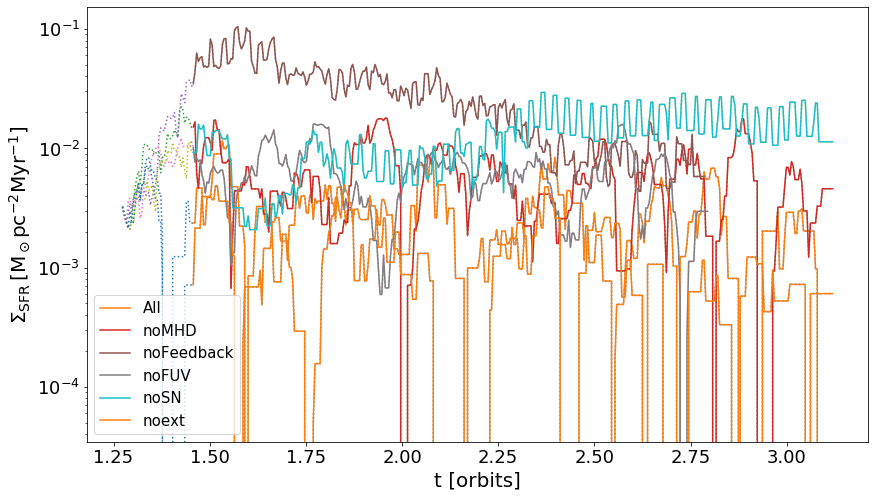

In [153]:
#Star formation  rate for physics variants
plt.figure(figsize=(14,8))
for pid in pids_phys:
    h=hsts_ph[pid]
    model = modname_ph[pid]
    plt.semilogy(h['torb'],h['sfr10'],linestyle=':')
    idx=(hsts_ph[pid]['tMyr']-hsts_ph[pid]['tMyr'].iloc[0]>40.)
    h=h[idx]
    plt.semilogy(h['torb'],h['sfr10'],label=model)
plt.legend(fontsize='small')
plt.xlabel('t [orbits]',fontsize=20)
plt.ylabel(labels['sfr']+label_units['sfr'],fontsize=20)

# Star formation rate vs. surface density

1233
1233
slope= 2.8470656151439835 intercept= -5.361381361868167


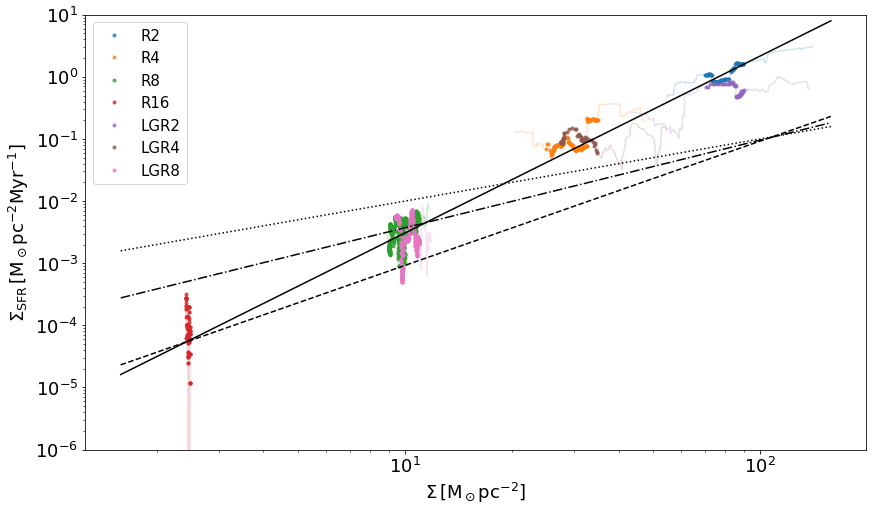

In [66]:
xf='surf'
yf='sfr40'
#yf='sfr10'

plt.figure(figsize=(14,8))
#create arrays for fitting across the models:
xall=np.array([])
yall=np.array([])    

for pid in pidsall:
    h=hsts[pid]
    p=pars[pid]
    model=pid.split('_')[0]
    #only plot for time > minimum 
    idx=(h['torb']>torb_min)
    h=h[idx]
    
    l,=plt.loglog(h[xf],h[yf],label='',alpha=0.2)
    
    # selecting ranges based on the surface density
    idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model])
    h=h[idx]
#    heavy=plt.plot(h[xf],h[yf],'.',color=l.get_color(),label=model,alpha=0.2)
    plt.plot(h[xf],h[yf],'.',color=l.get_color(),label=model,alpha=0.75)
    plt.legend(fontsize='small')

#exclude the lowest surface density  model  from fit
    if (model != 'R16'): 
        xall=np.append(xall,h[xf])
        yall=np.append(yall,h[yf])
#
#plt.legend(handles=[l])    
plt.ylim(1.e-6,10)
plt.xlabel(labels['surf']+label_units['surf'])
plt.ylabel(labels['sfr']+label_units['sfr'])
#add comparisons
Sig=np.logspace(0.2,2.2,100)
plt.plot(Sig,1.e-3*Sig,':k') # constant depletion time of 1 Myr
plt.plot(Sig,9.2e-6*Sig*Sig,'--k')  # from Ostriker & Shetty (2011), with chi =0 and fp=1
plt.plot(Sig,10.**(-3.84)*Sig**1.41,'-.k') #de los Reyes & Kennicutt (2019)
#fit the results:
print (xall.size)
print (yall.size)

slope, intercept, r_value, p_value, std_err = spst.linregress(np.log10(xall), np.log10(yall +1.e-10))
print ('slope=',slope,'intercept=',intercept)
plt.plot(Sig,10.**intercept*Sig**slope,'-k')



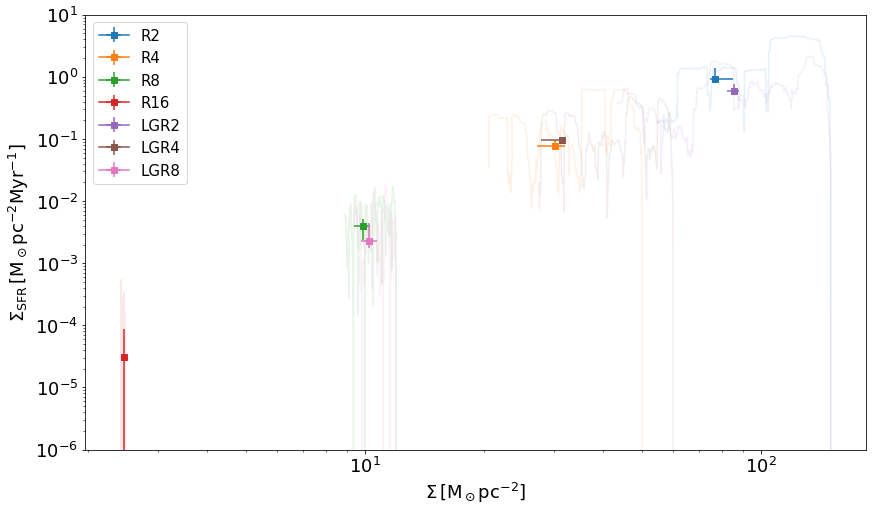

In [67]:
#This version calculates and plots means for each model 
legend_items=[]

xf='surf'
yf='sfr10'

plt.figure(figsize=(14,8))

for pid in pidsall:    
    h=hsts[pid]
    p=pars[pid]
    model=pid.split('_')[0]
    l,=plt.loglog(h[xf],h[yf],label='',alpha=0.1)    
# selecting ranges based on the surface density
    idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model])
    h=h[idx]
#consider only points with time > minimum and surface density  in target range 
#    idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model]) &  (h['torb']>torb_min)
#    h=h[idx]   
    # calculate 10, 50, 90 percentiles
    #for m,yf2 zip(['s','^','o'],['sfr10','sfr40','sfr100']):
    m='s'
    yf2='sfr40'
    xx=np.percentile(h[xf],[25,50,75])
    yy=np.percentile(h[yf2],[25,50,75])
    yerr=np.diff(yy).reshape(2,1)
    xerr=np.diff(xx).reshape(2,1)
    points=plt.errorbar(xx[1],yy[1],yerr=yerr,xerr=xerr,
                            color=l.get_color(),marker=m,label=model)
    #    if yf2 is 'sfr10': legend_items.append(points)
    legend_items.append(points)

plt.ylim(1.e-6,10)
plt.xlabel(labels['surf']+label_units['surf'])
plt.ylabel(labels['sfr']+label_units['sfr'])
plt.legend(handles=legend_items,fontsize='small')

Sig=np.logspace(0,2.5,100)
#plt.plot(Sig,1.e-3*Sig,':k') # constant depletion time of 1 Myr


In [69]:
#Compute mean and median SFR
xf='surf'
#yf='sfr40'
yf='sfr10'
#create dictionaries for mean and median
median_sig={}
median_sfr={}
mean_sig={}
mean_sfr={}
#compute mean and median
for pid in pidsall:
    h=hsts[pid]
    p=pars[pid]
    model=pid.split('_')[0]
    #consider only points with time > minimum and surface density  in target range 
    idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model]) &  (h['torb']>torb_min)
    h=h[idx]
    #compute median and mean SFR
    median_sig[pid]=np.percentile(h[xf],50)
    median_sfr[pid]=np.percentile(h[yf],50)
    mean_sig[pid]=np.mean(h[xf])
    mean_sfr[pid]=np.mean(h[yf])
for i, pid in enumerate(pids):
#    print pid,median_sig[pid],median_sfr[pid]
    print (pid, mean_sig[pid],mean_sfr[pid])


R2_2pc_L512_B2_norun 78.98738705701953 0.971910228555079
R4_2pc_L512_B10 29.769227864190803 0.06850188806095155
R8_4pc_newacc 9.86710210950746 0.0037076733834085903
R16_8pc_metal 2.460614062041957 6.324460793629474e-05


### Pressures

* `Pmid_2p`: total midplane pressure
* `W_2p`: weight of 2p gas directly calculated by integrating $\rho g_z$
* `PDE`: dynamical equilibrium pressure based on the numerically calculated $\chi=4\zeta_d \rho_{\rm sd}/\rho_0$
* `PDE2`: DE pressure based on the analytic expressions with $\sigma_z$ from the simulation

In [75]:
#set up key using model name and surface density
modname={}
for pid in pidsall:
    model=pid.split('_')[0]
    modname[pid]=model+': S={}'.format(surf_mean[model])
print (modname.values())

dict_values(['R2: S=80', 'R4: S=30', 'R8: S=10', 'R16: S=2.5', 'LGR2: S=80', 'LGR4: S=30', 'LGR8: S=10'])


# Pressure of two-phase gas and all gas

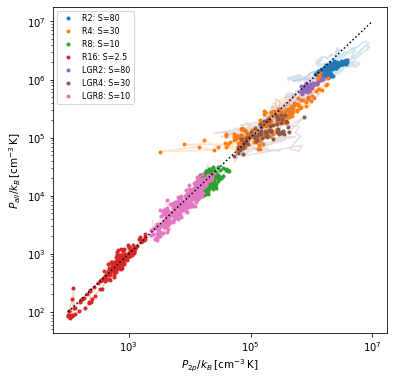

In [76]:
fig=plt.figure(figsize=(6,6))
legend_items=[]
yf='Pmid'
xf='Pmid_2p'
torb_min=0.2
for pid in pidsall:
    h=hsts[pid]
    p=pars[pid]
    model=pid.split('_')[0]
#    modelname=model+': S={}'.format(surf_mean[model])
#only plot for time > minimum 
    idx=(h['torb']>torb_min)
    h=h[idx] 
    l,=plt.loglog(h[xf],h[yf],label='',alpha=0.2)
    # selecting ranges based on the surface density
    idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model])
    h=h[idx]
#    plt.plot(h[xf],h[yf],color=l.get_color(),label=model,alpha=1.)    
#    plt.plot(h[xf],h[yf],color=l.get_color(),label=modelname,alpha=1.)
    plt.plot(h[xf],h[yf],'.',color=l.get_color(),label=modname[pid],alpha=1.)
#    plt.legend(fontsize='xx-small')
    plt.legend(prop={'size':8})
plt.xlabel('$P_{2p}$'+'/$k_B$'+label_units['pressure'],fontsize='xx-small')
plt.ylabel('$P_{all}$'+'/$k_B$'+label_units['pressure'],fontsize='xx-small')
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.plot([100,1.e7],[100,1.e7],':k')

# Pressure vs. density at midplane

1459
1459
slope= 1.4176411211217728 intercept= 4.716689222582347
1459
1459
slope= 1.3985729403162794 intercept= 4.282594183927366


/tigress/eostrike/miniconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/tigress/eostrike/miniconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


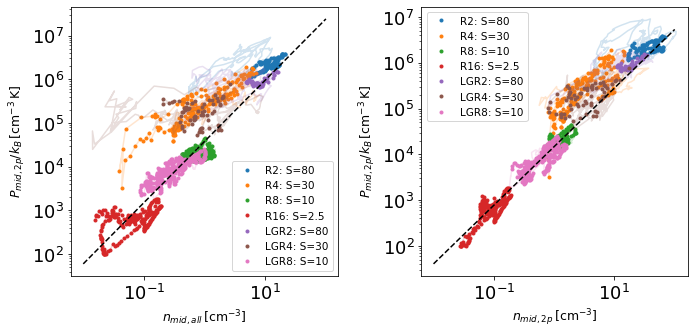

In [77]:
fig=plt.figure(figsize=(10,5))
#yf='Pmid'
yf='Pmid_2p'
nfit=np.logspace(-2,2,100)
torb_min=0.2
for i,xf in enumerate(['nmid','nmid_2p']):
    plt.subplot(1,2,i+1)
#set up for fitting    
    xall=np.array([])
    yall=np.array([])    
    for pid in pidsall:
        h=hsts[pid]
        p=pars[pid]
        model=pid.split('_')[0]
#    modelname=model+': S={}'.format(surf_mean[model])
#only plot for time > minimum 
        idx=(h['torb']>torb_min)
        h=h[idx] 
        l,=plt.loglog(h[xf],h[yf],label='',alpha=0.2)
# selecting ranges based on the surface density
        idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model])
        h=h[idx]
        xall=np.append(xall,h[xf])
        yall=np.append(yall,h[yf])
#    plt.plot(h[xf],h[yf],color=l.get_color(),label=model,alpha=1.)    
#    plt.plot(h[xf],h[yf],color=l.get_color(),label=modelname,alpha=1.)
        plt.plot(h[xf],h[yf],'.',color=l.get_color(),label=modname[pid],alpha=1.)
    plt.legend(fontsize='xx-small')
#    plt.ylabel('$P_{mid}$'+'/$k_B$'+label_units['pressure'],fontsize='x-small') 
    plt.ylabel('$P_{mid,2p}$'+'/$k_B$'+label_units['pressure'],fontsize='x-small') 
    print (xall.size)
    print (yall.size)
    slope, intercept, r_value, p_value, std_err = spst.linregress(np.log10(xall), np.log10(yall))
    print ('slope=',slope,'intercept=',intercept)
#    plt.plot(nfit,slope*nfit+intercept,'--k')
plt.subplot(1,2,1)
plt.xlabel('$n_{mid,all}$'+label_units['density'],fontsize='x-small')
#plt.plot(nfit,3e4*(nfit)**1.4,':k') 
plt.plot(nfit,10.**4.58*(nfit)**1.40,'--k')
plt.subplot(1,2,2)
plt.xlabel('$n_{mid,2p}$'+label_units['density'],fontsize='x-small')
#plt.plot(nfit,1.5e4*(nfit)**1.3, ':k') 
plt.plot(nfit,10.**4.17*(nfit)**1.28,'--k')

plt.tight_layout()

# Measured midplane pressure vs. actual weight and estimated weight

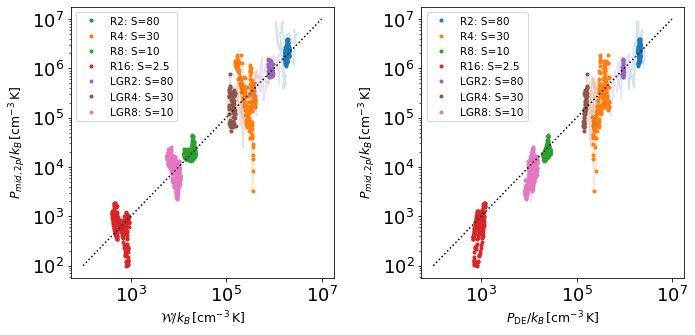

In [78]:
fig=plt.figure(figsize=(10,5))
#yf='Pmid'
yf='Pmid_2p'
torb_min=0.2
for i,xf in enumerate(['W','PDE2']):
    plt.subplot(1,2,i+1)
    for pid in pidsall:
        h=hsts[pid]
        p=pars[pid]
        model=pid.split('_')[0]
#    modelname=model+': S={}'.format(surf_mean[model])
#only plot for time > minimum 
        idx=(h['torb']>torb_min)
        h=h[idx]
        l,=plt.loglog(h[xf],h[yf],label='',alpha=0.2)
# selecting ranges based on the surface density
        idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model])
        h=h[idx]
#    plt.plot(h[xf],h[yf],color=l.get_color(),label=model,alpha=1.)    
#    plt.plot(h[xf],h[yf],color=l.get_color(),label=modelname,alpha=1.)
        plt.plot(h[xf],h[yf],'.',color=l.get_color(),label=modname[pid],alpha=1.)
        plt.legend(fontsize='xx-small')
#    plt.ylabel('$P_{mid}$'+'/$k_B$'+label_units['pressure'],fontsize='x-small')
    plt.ylabel('$P_{mid,2p}$'+'/$k_B$'+label_units['pressure'],fontsize='x-small')
    plt.xlabel(labels[xf]+'/$k_B$'+label_units['pressure'],fontsize='x-small')
    plt.plot([100,1.e7],[100,1.e7],':k') 
plt.tight_layout()

(array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
        1.e+08, 1.e+09]), <a list of 10 Text yticklabel objects>)

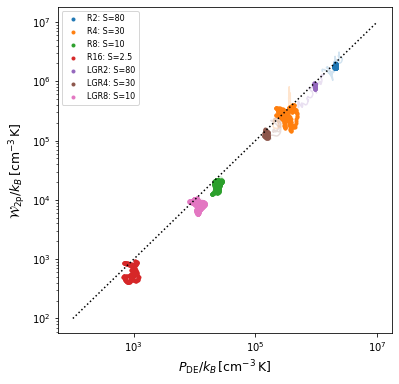

In [79]:
#Actual weight vs. estimated weight 
fig=plt.figure(figsize=(6,6))
legend_items=[]
yf='W_2p'
xf='PDE2'
torb_min=0.2
for pid in pidsall:
    h=hsts[pid]
    p=pars[pid]
    model=pid.split('_')[0]
#    modelname=model+': S={}'.format(surf_mean[model])
#only plot for time > minimum 
    idx=(h['torb']>torb_min)
    h=h[idx] 

    l,=plt.loglog(h[xf],h[yf],label='',alpha=0.2)
    # selecting ranges based on the surface density
    idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model])
    h=h[idx]
#    plt.plot(h[xf],h[yf],color=l.get_color(),label=model,alpha=1.)    
#    plt.plot(h[xf],h[yf],color=l.get_color(),label=modelname,alpha=1.)
    plt.plot(h[xf],h[yf],'.',color=l.get_color(),label=modname[pid],alpha=1.)
    plt.legend(prop={'size':8})
plt.ylabel(labels[yf]+'/$k_B$'+label_units['pressure'],fontsize='x-small')
plt.xlabel(labels[xf]+'/$k_B$'+label_units['pressure'],fontsize='x-small')
plt.plot([100,1.e7],[100,1.e7],':k') 
plt.xticks(size=10)
plt.yticks(size=10)

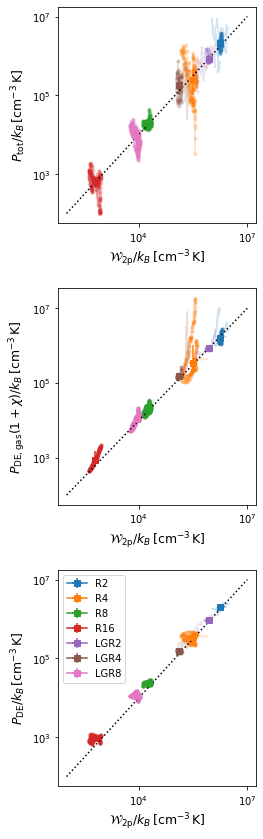

In [80]:
#Various quantities vs. W_2p
fig=plt.figure(figsize=(4,12))

torb_min=0.2
for i,yf in enumerate(['Pmid_2p','PDE','PDE2']):
    plt.subplot(3,1,i+1)
    legend_items=[]
    xf='W_2p'

    for pid in pidsall:
        h=hsts[pid]
        p=pars[pid]
        model=pid.split('_')[0]
        #only plot for time > minimum 
        idx=(h['torb']>torb_min)
        h=h[idx] 
        l,=plt.loglog(h[xf],h[yf],label='',alpha=0.2)

        # selecting ranges based on the surface density
        idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model])
        h=h[idx]
        plt.plot(h[xf],h[yf],'.',color=l.get_color(),label=model,alpha=0.2)
        
        # calculate 10, 50, 90 percentiles
        x=np.percentile(h[xf],[25,50,75])
        y=np.percentile(h[yf],[25,50,75])
        yerr=np.diff(y).reshape(2,1)
        xerr=np.diff(x).reshape(2,1)
        points=plt.errorbar(x[1],y[1],yerr=yerr,xerr=xerr,
                            color=l.get_color(),marker='s',label=model)
        legend_items.append(points)
        plt.xticks(size=10)
        plt.yticks(size=10)
    plt.ylabel(labels[yf]+'/$k_B$'+label_units['pressure'],fontsize='x-small',)
    plt.xlabel(labels['W_2p']+'/$k_B$'+label_units['pressure'],fontsize='x-small',)
    plt.plot([100,1.e7],[100,1.e7],':k')
plt.legend(handles=legend_items,prop={'size':10})
plt.tight_layout()

#  SFR vs. actual midplane pressure and predicted midplane pressure, for two-phase gas

/tigress/eostrike/miniconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/tigress/eostrike/miniconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


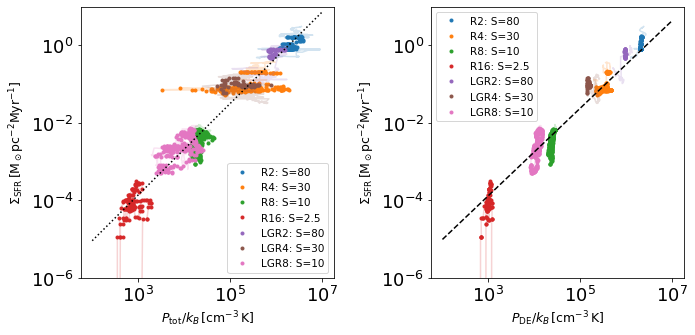

In [81]:
fig=plt.figure(figsize=(10,5))
yf='sfr40'
for i,xf in enumerate(['Pmid_2p','PDE2']):
    plt.subplot(1,2,i+1)
    for pid in pidsall:
        h=hsts[pid]
        p=pars[pid]
        model=pid.split('_')[0]
#    modelname=model+': S={}'.format(surf_mean[model])        
        #only plot for time > minimum 
        idx=(h['torb']>torb_min)
        h=h[idx] 
        l,=plt.loglog(h[xf],h[yf],label='',alpha=0.2)
# selecting ranges based on the surface density
        idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model])
        h=h[idx]
#    plt.plot(h[xf],h[yf],color=l.get_color(),label=model,alpha=1.)    
#    plt.plot(h[xf],h[yf],color=l.get_color(),label=modelname,alpha=1.)
        plt.plot(h[xf],h[yf],'.',color=l.get_color(),label=modname[pid],alpha=1.)
        plt.legend(fontsize='xx-small')
    plt.ylabel(labels['sfr']+label_units['sfr'],fontsize='x-small')
    plt.xlabel(labels[xf]+'/$k_B$'+label_units['pressure'],fontsize='x-small')  
    plt.ylim(1.e-6,10)
Pfit=np.logspace(2,7,100)
plt.subplot(1,2,1)
plt.plot(Pfit,2.1e-3*(Pfit/1.e4)**1.18,':k') # KOK13 Eq. (26) -- fit to Ptot
plt.subplot(1,2,2)
plt.plot(Pfit,1.8e-3*(Pfit/1.e4)**1.13,'--k') # KOK13 Eq. (27) -- fit to PDE

plt.tight_layout()

/tigress/eostrike/miniconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/tigress/eostrike/miniconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/tigress/eostrike/miniconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same argument

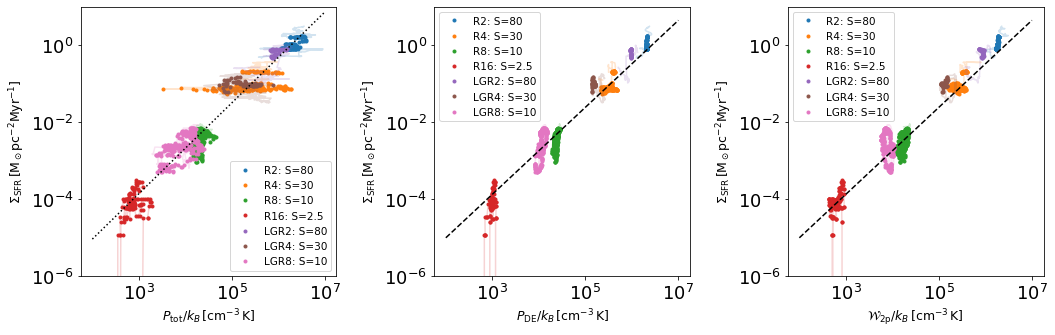

In [82]:
fig=plt.figure(figsize=(15,5))
yf='sfr40'
for i,xf in enumerate(['Pmid_2p','PDE2','W_2p']):
    plt.subplot(1,3,i+1)
    for pid in pidsall:
        h=hsts[pid]
        p=pars[pid]
        model=pid.split('_')[0]
#    modelname=model+': S={}'.format(surf_mean[model])        
        #only plot for time > minimum 
        idx=(h['torb']>torb_min)
        h=h[idx] 
        l,=plt.loglog(h[xf],h[yf],label='',alpha=0.2)
# selecting ranges based on the surface density
        idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model])
        h=h[idx]
#    plt.plot(h[xf],h[yf],color=l.get_color(),label=model,alpha=1.)    
#    plt.plot(h[xf],h[yf],color=l.get_color(),label=modelname,alpha=1.)
        plt.plot(h[xf],h[yf],'.',color=l.get_color(),label=modname[pid],alpha=1.)
        plt.legend(fontsize='xx-small')
    plt.ylabel(labels['sfr']+label_units['sfr'],fontsize='x-small')
    plt.xlabel(labels[xf]+'/$k_B$'+label_units['pressure'],fontsize='x-small')  
    plt.ylim(1.e-6,10)
Pfit=np.logspace(2,7,100)
plt.subplot(1,3,1)
plt.plot(Pfit,2.1e-3*(Pfit/1.e4)**1.18,':k') # KOK13 Eq. (26) -- fit to Ptot
plt.subplot(1,3,2)
plt.plot(Pfit,1.8e-3*(Pfit/1.e4)**1.13,'--k') # KOK13 Eq. (27) -- fit to PDE
plt.subplot(1,3,3)
plt.plot(Pfit,1.8e-3*(Pfit/1.e4)**1.13,'--k') # KOK13 Eq. (27) -- fit to PDE

plt.tight_layout()

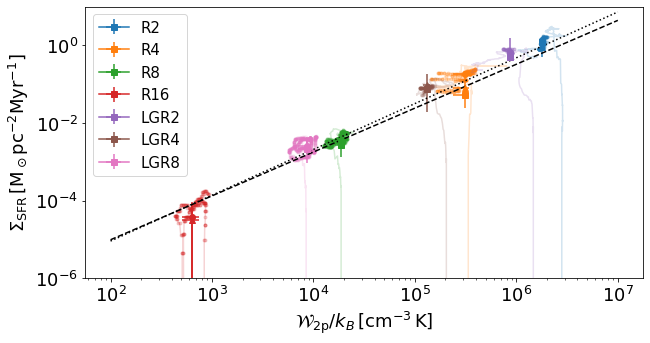

In [83]:
legend_items=[]
fig=plt.figure(figsize=(10,5))
xf='W_2p'
yf='sfr40'

for pid in pidsall:
    h=hsts[pid]
    p=pars[pid]
    model=pid.split('_')[0]
    
    l,=plt.loglog(h[xf],h[yf],label='',alpha=0.2)
    
    # selecting ranges based on the surface density
    idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model])
    h=h[idx]
    plt.plot(h[xf],h[yf],'.',color=l.get_color(),label=model,alpha=0.2)
    
    # calculate 10, 50, 90 percentiles
    for m,yf in zip(['s','^','o'],['sfr10','sfr40','sfr100']):
        x=np.percentile(h[xf],[25,50,75])
        y=np.percentile(h[yf],[25,50,75])
        yerr=np.diff(y).reshape(2,1)
        xerr=np.diff(x).reshape(2,1)
        points=plt.errorbar(x[1],y[1],yerr=yerr,xerr=xerr,
                            color=l.get_color(),marker=m,label=model)
        if yf is 'sfr10': legend_items.append(points)

Pfit=np.logspace(2,7,100)
plt.plot(Pfit,2.1e-3*(Pfit/1.e4)**1.18,':k') # KOK13 Eq. (26) -- fit to Ptot
plt.plot(Pfit,1.8e-3*(Pfit/1.e4)**1.13,'--k') # KOK13 Eq. (27) -- fit to PDE
plt.ylim(1.e-6,10)
plt.xlabel(labels['W_2p']+'/$k_B$'+label_units['pressure'])
plt.ylabel(labels['sfr']+label_units['sfr'])
plt.legend(handles=legend_items,fontsize='small')

In [84]:
surf_min={'R2':70,'R4':35,'R8':9,'R16':2.4,'LGR2':70,'LGR4':35,'LGR8':9,}
surf_max={'R2':90,'R4':45,'R8':11,'R16':2.6,'LGR2':90,'LGR4':45,'LGR8':11}


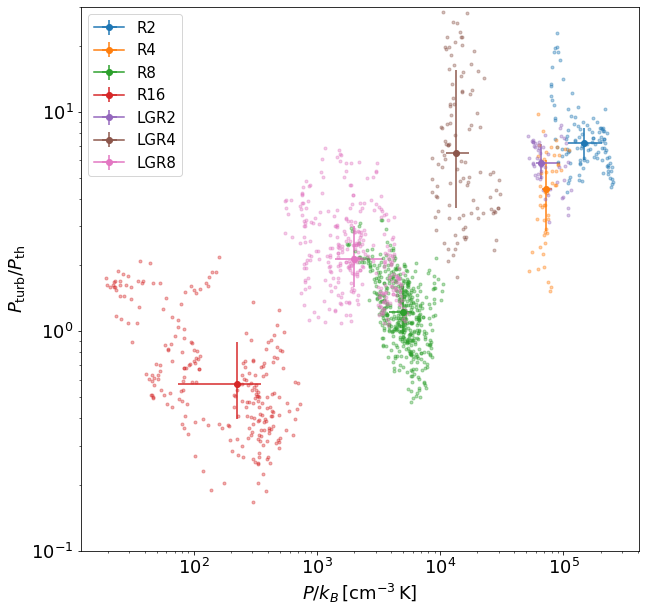

In [85]:
#ratio of turbulent support to thermal support
legend_items=[]
xf='Pth_mid_2p'
yf='Pturb_mid_2p'

plt.ylim(1.e-1,30)
for pid in pidsall:
    h=hsts[pid]
    p=pars[pid]
    model=pid.split('_')[0]
    #only plot for time > minimum 
    idx=(h['tMyr']>40.)
    h=h[idx]    
    idx =(h['sfr10']> 0.)
    idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model])
    h=h[idx]
    l,=plt.plot(h[xf],h[yf]/h[xf],'.',label=model,alpha=0.2)
    

    # selecting ranges for averages based on the surface density
    idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model])
    h=h[idx]
    l,=plt.plot(h[xf],h[yf]/h[xf],'.',color=l.get_color(),label=model,alpha=0.2)
    
    # calculate  percentiles
    x=np.percentile(h[xf],[25,50,75])

    y=np.percentile(h[yf]/h[xf],[25,50,75])

    yerr=np.diff(y).reshape(2,1)
    xerr=np.diff(x).reshape(2,1)
    points=plt.errorbar(x[1],y[1],yerr=yerr,xerr=xerr,
                        marker=m,color=l.get_color(),label=model,alpha=1.)
    legend_items.append(points)
plt.xlabel(labels['Pth']+label_units['pressure'])
plt.ylabel(labels['Pturb_mid_2p']+'/'+labels['Pth_mid_2p'])
plt.xscale('log')
plt.yscale('log')
plt.legend(handles=legend_items,fontsize='small')

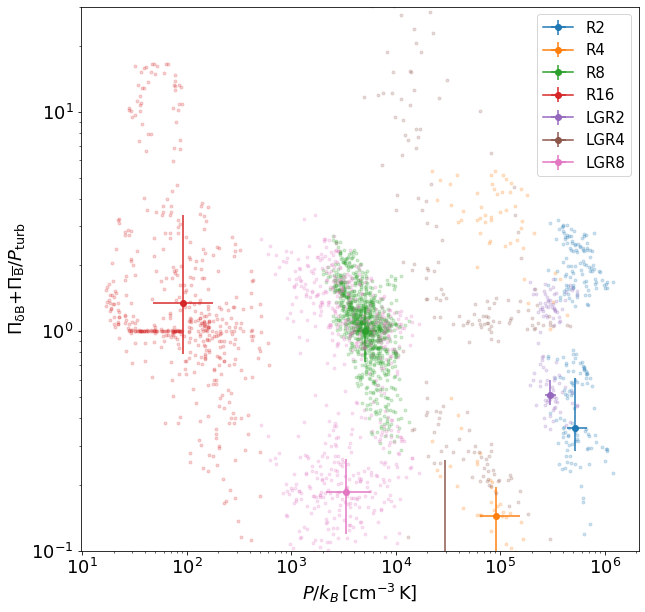

In [86]:
#Ratio of magnetic support to turbulent support
legend_items=[]
#xf='Pturb_mid_2p'
#yf1='Pimag_mean_mid_2p'
#yf2='Pimag_turb_mid_2p'
xf='Pturb_mid'
yf1='Pimag_mean_mid'
yf2='Pimag_turb_mid'

plt.ylim(1.e-1,30)
for pid in pidsall:
    h=hsts[pid]
    p=pars[pid]
    model=pid.split('_')[0]
    #only plot for time > minimum 
    idx=(h['tMyr']>40.)
    h=h[idx]    
    idx =(h['sfr10']> 0.)
    idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model])
    h=h[idx]
    l,=plt.plot(h[xf],h[yf]/h[xf],'.',label=model,alpha=0.2)
    

    # selecting ranges for averages based on the surface density
    idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model])
    h=h[idx]
    l,=plt.plot(h[xf],(h[yf1]+h[yf2])/h[xf],'.',color=l.get_color(),label=model,alpha=0.2)
    
    # calculate  percentiles
    x=np.percentile(h[xf],[25,50,75])

    y=np.percentile((h[yf1]+h[yf2])/h[xf],[25,50,75])

    yerr=np.diff(y).reshape(2,1)
    xerr=np.diff(x).reshape(2,1)
    points=plt.errorbar(x[1],y[1],yerr=yerr,xerr=xerr,
                        marker=m,color=l.get_color(),label=model,alpha=1.)
    legend_items.append(points)
plt.xlabel(labels['Pth']+label_units['pressure'])
plt.ylabel(labels['Pimag_turb_mid_2p']+'+'+labels['Pimag_mean_mid_2p']+'/'+labels['Pturb_mid_2p'])
plt.xscale('log')
plt.yscale('log')
plt.legend(handles=legend_items,fontsize='small')

In [90]:
etaconvert = (1.e6*c.k_B/(c.M_sun/(c.kpc**2*u.yr))/(u.km/u.s)).cgs.value
print (etaconvert)

208.62577513852398


In [150]:
h=hsts['R8_4pc_newacc']
eta_th=(h['Pth_mid_2p']/1.e3)/(h['sfr40']/1.e-3)
print (eta_th)
etath0=np.percentile(eta_th,50)
print (etath0)
etath_0=np.median(eta_th)
print (etath0)
type(etath0)

taxis
0.00000           inf
1.00412           inf
2.00044           inf
3.00590           inf
4.00193           inf
               ...   
670.00100    2.268494
671.00000    2.248616
672.00000    2.300725
673.00100    2.173371
673.35100    2.157215
Length: 675, dtype: float64
1.3833496203367488
1.3833496203367488


numpy.float64

In [151]:
# calculate reference values (solar nbhd model) of eta in old units (pressure and SFR) and new units (km/s)

h=hsts['R8_4pc_newacc']
model=pid.split('_')[0]

idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model]) & (h['sfr40'] != 0)
h=h[idx]

#all midplane:
#eta_th=(h['Pth_mid']/1.e3)/(h['sfr40']/1.e-3)
#eta_turb=(h['Pturb_mid']/1.e3)/(h['sfr40']/1.e-3)
#eta_mag=((h['Pimag_mean_mid']+h['Pimag_turb_mid'])/1.e3)/(h['sfr40']/1.e-3)
#two-phase only:
eta_th=(h['Pth_mid_2p']/1.e3)/(h['sfr40']/1.e-3)
eta_turb=(h['Pturb_mid_2p']/1.e3)/(h['sfr40']/1.e-3)
eta_mag=((h['Pimag_mean_mid_2p']+h['Pimag_turb_mid_2p'])/1.e3)/(h['sfr40']/1.e-3)

#eta_th0=np.percentile(eta_th,50)
#eta_turb0=np.percentile(eta_turb,50)
#eta_mag0=np.percentile(eta_mag,50)
#eta_tot0=eta_th0+eta_turb0+eta_mag0
#nmid0=np.percentile(h['nmid'],50)

eta_th0=np.median(eta_th)
eta_turb0=np.median(eta_turb)
eta_mag0=np.median(eta_mag)
eta_tot0=eta_th0+eta_turb0+eta_mag0
nmid0=np.median(h['nmid'])

#eta_th0=eta_th.mean()
#eta_turb0=eta_turb.mean()
#nmid0=nmid.mean()
print (eta_th0,eta_turb0,eta_mag0,eta_tot0,nmid0)
print (eta_th0*etaconvert,eta_turb0*etaconvert,eta_mag0*etaconvert,eta_tot0*etaconvert,nmid0)

nan nan nan nan nan
nan nan nan nan nan


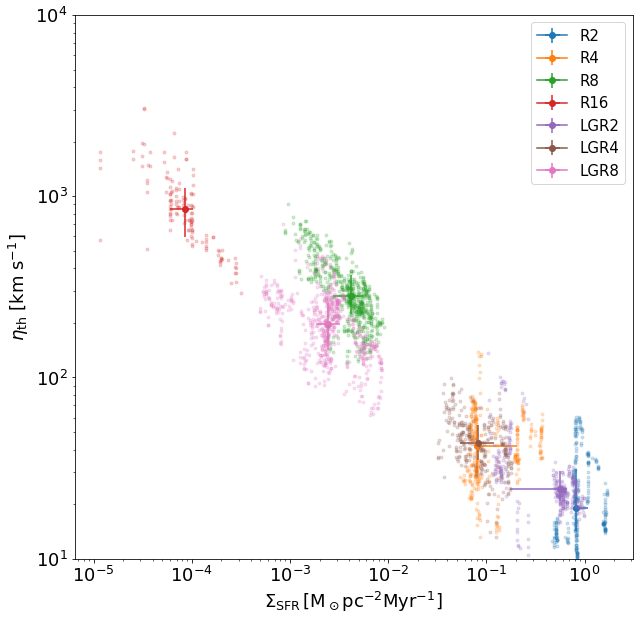

In [92]:
#
legend_items=[]
xf='sfr40'
yf='Pth_mid_2p'

set_norm=False
sfr=[]
#ftau=[]

plt.ylim(10.,1.e4)
for pid in pidsall:
    h=hsts[pid]
    p=pars[pid]
    model=pid.split('_')[0]

    # selecting ranges based on the surface density 
#    idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model]) & (h['sfr40'] > 1.e-10) 
    # select range for all points based on time 
    idx=(h['tMyr']>40.) & (h['sfr40'] > 1.e-10)
    h=h[idx]
#    if pid is 'R16_16pc_metal':
#        xf='sfr40'
#    else:
#        xf='sfr10'
    etaold=(h[yf]/1.e3)/(h[xf]/1.e-3)
    eta=etaold*etaconvert
    l,=plt.plot(h[xf],eta,'.',label=model,alpha=0.2)
    
    # calculate percentiles
    x=np.percentile(h[xf],[25,50,75])
    
    y=np.percentile(eta,[25,50,75])
    yerr=np.diff(y).reshape(2,1)
    xerr=np.diff(x).reshape(2,1)
        
    points=plt.errorbar(x[1],y[1],yerr=yerr,xerr=xerr,
                        marker='o',color=l.get_color(),label=model,alpha=1,zorder=-1)
    legend_items.append(points)

    
#    y2=np.percentile(eta_th0*h['ftau_hst'],[25,50,75])
#    y2err=np.diff(y2).reshape(2,1)

#    points=plt.errorbar(x[1],y2[1],yerr=y2err,xerr=xerr,marker='s',label=model,color='k',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(labels['sfr']+label_units['sfr'])
plt.ylabel(r'$\eta_{\rm th}$'+ r' [$\rm km\ s^{-1}$]')
plt.legend(handles=legend_items,fontsize='small')

## Plot all of the eta values vs. Sigma_SFR

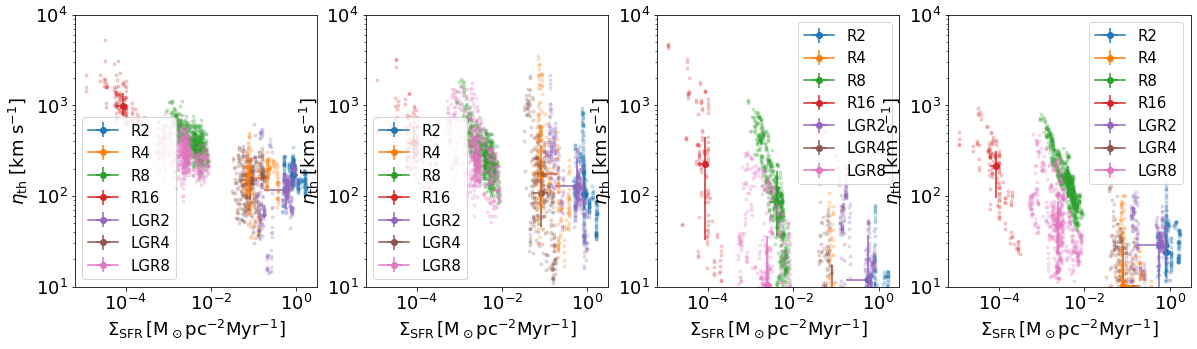

In [93]:
#
legend_items=[]
xf='sfr40'

#set_norm=False

fig=plt.figure(figsize=(20,5))

for i,yf in enumerate(['Pth_mid','Pturb_mid','Pimag_mean_mid','Pimag_turb_mid']):
    plt.subplot(1,4,i+1)
    plt.ylim(10.,1.e4)

    for pid in pidsall:
        h=hsts[pid]
        p=pars[pid]
        model=pid.split('_')[0]

    # selecting ranges based on the surface density 
#    idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model]) & (h['sfr40'] > 1.e-10) 
    # select range for all points based on time 
        idx=(h['tMyr']>40.) & (h['sfr40'] > 1.e-10)
        h=h[idx]
        etaold=(h[yf]/1.e3)/(h[xf]/1.e-3)
        eta=etaold*etaconvert
        l,=plt.loglog(h[xf],eta,'.',label=model,alpha=0.2)
    
    # calculate percentiles
        x=np.percentile(h[xf],[25,50,75])
    
        y=np.percentile(eta,[25,50,75])
        yerr=np.diff(y).reshape(2,1)
        xerr=np.diff(x).reshape(2,1)
        
        points=plt.errorbar(x[1],y[1],yerr=yerr,xerr=xerr,
                        marker='o',color=l.get_color(),label=model,alpha=1,zorder=-1)
        if yf is 'Pth_mid': legend_items.append(points)

        plt.xlabel(labels['sfr']+label_units['sfr'])
        plt.ylabel(r'$\eta_{\rm th}$'+ r' [$\rm km\ s^{-1}$]')
        plt.legend(handles=legend_items,fontsize='small')

NameError: name 'eta_turb0' is not defined

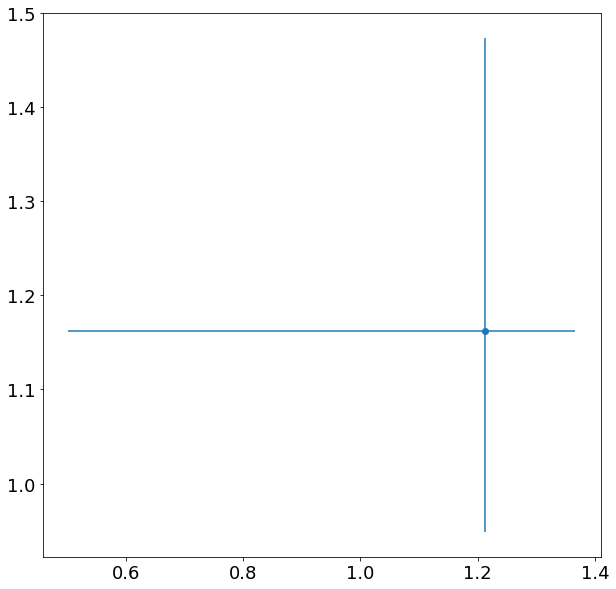

In [94]:
legend_items=[]
xf='sfr10'
yf='Pturb_mid_2p'

set_norm=False
sfr=[]
nmid=[]
for pid in pids:
    h=hsts[pid]
    p=pars[pid]
    model=pid.split('_')[0]

    # selecting ranges based on the surface density
    idx=(h['surf'] > surf_min[model]) & (h['surf'] < surf_max[model]) & (h['sfr40'] > 1.e-10)
    h=h[idx]
    if pid is 'R16_16pc_metal':
        xf='sfr40'
    else:
        xf='sfr10'
    
    # calculate 10, 50, 90 percentiles
    x=np.percentile(h[xf],[25,50,75])
    eta=(h[yf]/1.e3)/(h[xf]/1.e-3)

    y=np.percentile(eta,[25,50,75])
    yerr=np.diff(y).reshape(2,1)
    xerr=np.diff(x).reshape(2,1)

    points=plt.errorbar(x[1],y[1],yerr=yerr,xerr=xerr,
                        marker=m,label=model)
    
    y2=np.percentile(eta_turb0*(h['nmid']/nmid0)**(-0.17),[25,50,75])
    y2err=np.diff(y2).reshape(2,1)

    points=plt.errorbar(x[1],y2[1],yerr=y2err,xerr=xerr,
                        marker='s',label=model,color='k',alpha=0.5)

plt.xscale('log')
plt.xlabel(labels['sfr']+label_units['sfr'])
plt.ylabel(r'$\eta_{\rm turb}$')
plt.legend(handles=legend_items,fontsize='small')